In [1]:
import os
import pandas as pd
import numpy as np

folder_path = 'WC' # specify the folder path containing your CSV files
files = [file for file in os.listdir(folder_path) if file.endswith('.csv')] # get a list of all CSV files in the folder

# loop through each file and load it into a DataFrame
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, usecols=[0, 1, 2], parse_dates=[0]) # the parser will automatically convert the first column to datetime!
    df.set_index('Date_Time', inplace=True) # set the datetime column as the index
    variable_name = f'{file.split(".")[0].replace("-", "_").replace(" ", "_").replace(".", "_")}'
    exec(f"{variable_name} = df") 

I need to interpolate the time values, since the start and end time for the barometer is different.

In [2]:
# get the barometric DataFrame
barom_df = eval('BAROM_23')
# resample the DataFrame to a 5-minute frequency
barom_df_resampled = barom_df.resample('5T')
# interpolate the missing values
barom_df_interpolated = barom_df_resampled.interpolate(method='time')
print(barom_df_interpolated.index)
BAROM_23 = barom_df_interpolated

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 00:05:00',
               '2023-03-01 00:10:00', '2023-03-01 00:15:00',
               '2023-03-01 00:20:00', '2023-03-01 00:25:00',
               '2023-03-01 00:30:00', '2023-03-01 00:35:00',
               '2023-03-01 00:40:00', '2023-03-01 00:45:00',
               ...
               '2023-09-17 23:00:00', '2023-09-17 23:05:00',
               '2023-09-17 23:10:00', '2023-09-17 23:15:00',
               '2023-09-17 23:20:00', '2023-09-17 23:25:00',
               '2023-09-17 23:30:00', '2023-09-17 23:35:00',
               '2023-09-17 23:40:00', '2023-09-17 23:45:00'],
              dtype='datetime64[ns]', name='Date_Time', length=57886, freq='5T')


Add the barometric pressure as a new column to each DataFrame:

In [4]:
# get the barometric DataFrame
barom_df = eval('BAROM_23')
# rename the pressure column name to barom
barom_df.rename(columns={'Pressure': 'Barom'}, inplace=True)

# iterate over all file names in the 'files' list
for file in files:
    # get the DataFrame name by removing the '.csv' extension from the file name
    df_name = file[:-4]
    
    if df_name != 'BAROM_23': # skip the 'BAROM_SM23' DataFrame
        # get the DataFrame by its variable name
        df = eval(df_name)
        # merge the column from 'BAROM_SM23' DataFrame on the index
        df = df.join(barom_df['Barom'])
        # drop the rows with missing values
        df.dropna(inplace=True)
        # assign the result back to the DataFrame variable
        exec(f"{df_name} = df")

First we will calculate the WC above the divers, which can be estimated as: 

$WC = 9806.65 * \frac{(P_{diver} - P_{baro})}{\rho g}$

In [7]:
g = 9.81 #(m/s^2)
rho = 1000 #(kg/m^3)

for i, file in enumerate(files):
    # get the DataFrame name by removing the '.csv' extension from the file name
    df_name = file[:-4]
    if df_name != 'BAROM_23': # skip the 'BAROM_SM23' DataFrame
        # get the DataFrame by its variable name
        print(df_name)
        df = eval(df_name)

        #get the parameters
        pressure = df['Pressure']   # pressure reading in cmH2O
        temp = df['Temperature']    # water temperature in degrees Celsius
        barom = df['Barom']  # atmospheric pressure in cmH2O

        # calculate the water column above the diver in cmH2O
        WC = ((pressure - barom) / (rho * 9.81)) * 9806.65

        # add the water depth as a new column to the DataFrame
        df['WC'] = WC

        # Save the DataFrame to a CSV file
        df.to_csv(f"{df_name}_WC.csv")

        # Assign the result back to the DataFrame variable
        exec(f"{df_name} = df")

P1A_23
P1B_23
P1C_23
P2A_23
P2B_23
P2C_23
P3A_23
P3B_23
P3C_23
P4A_23
P4B_23
P4C_23
P5A_23
P5B_23
P5C_23
P6A_23
P6B_23
P6C_23


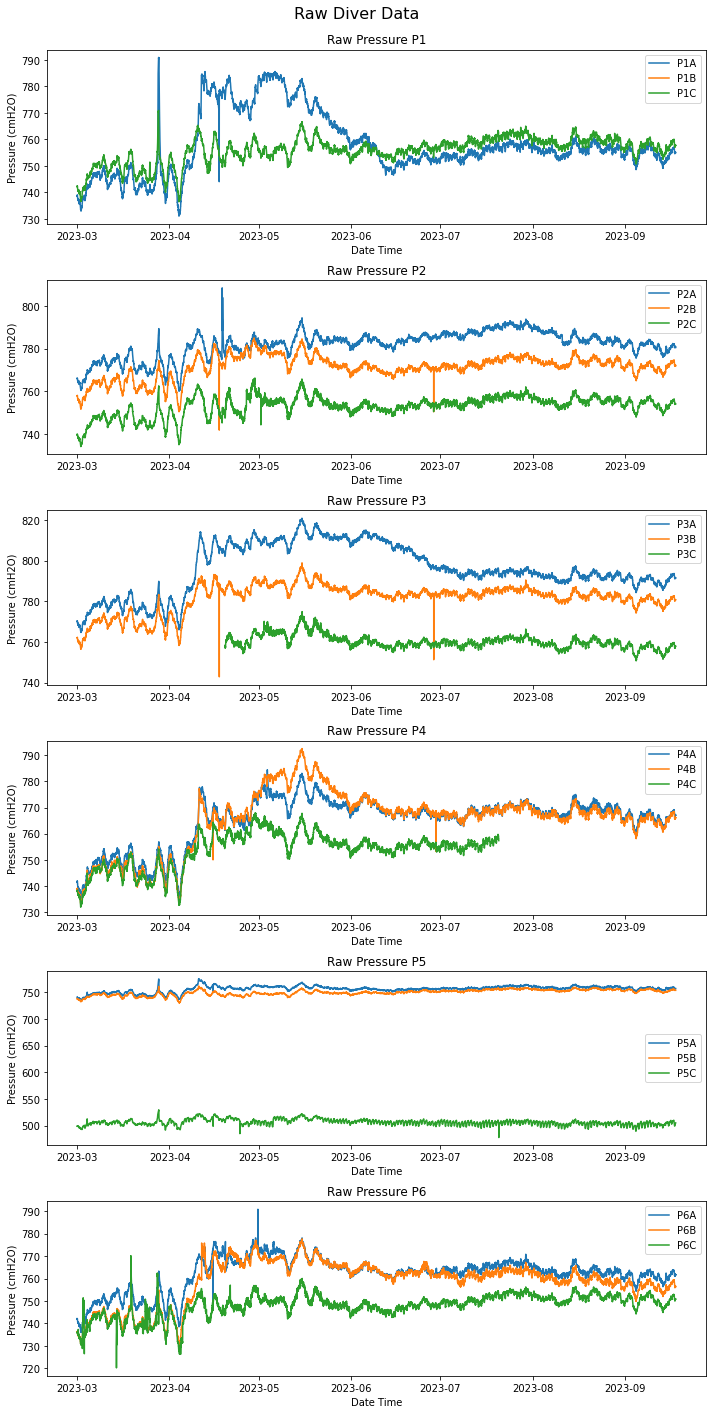

In [20]:
import matplotlib.pyplot as plt

# Create a new figure with 6 subplots
fig, axs = plt.subplots(6, figsize=(10, 20))
fig.patch.set_facecolor('white')

# List of pipe letters
pipes = ['A', 'B', 'C']

# Iterate over the piezometer numbers and the axes
for i, ax in enumerate(axs, start=1):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the DataFrame name
        df_name = f'P{i}{pipe}_23'
        # Get the DataFrame by its variable name
        df = eval(df_name)
        # Plot the 'WC' series
        ax.plot(df['Pressure'], label=f'P{i}{pipe}')
    # Set the title and labels
    ax.set_title(f'Raw Pressure P{i}')
    ax.set_xlabel('Date Time')
    ax.set_ylabel('Pressure (cmH2O)')
    # Add a legend
    ax.legend()

# Adjust the layout
plt.tight_layout()
fig.suptitle('Raw Diver Data', fontsize=16)
plt.subplots_adjust(top=0.95)

# Display the plots
plt.savefig('Raw_Diver_Data_2023.png', dpi=300)
plt.show()

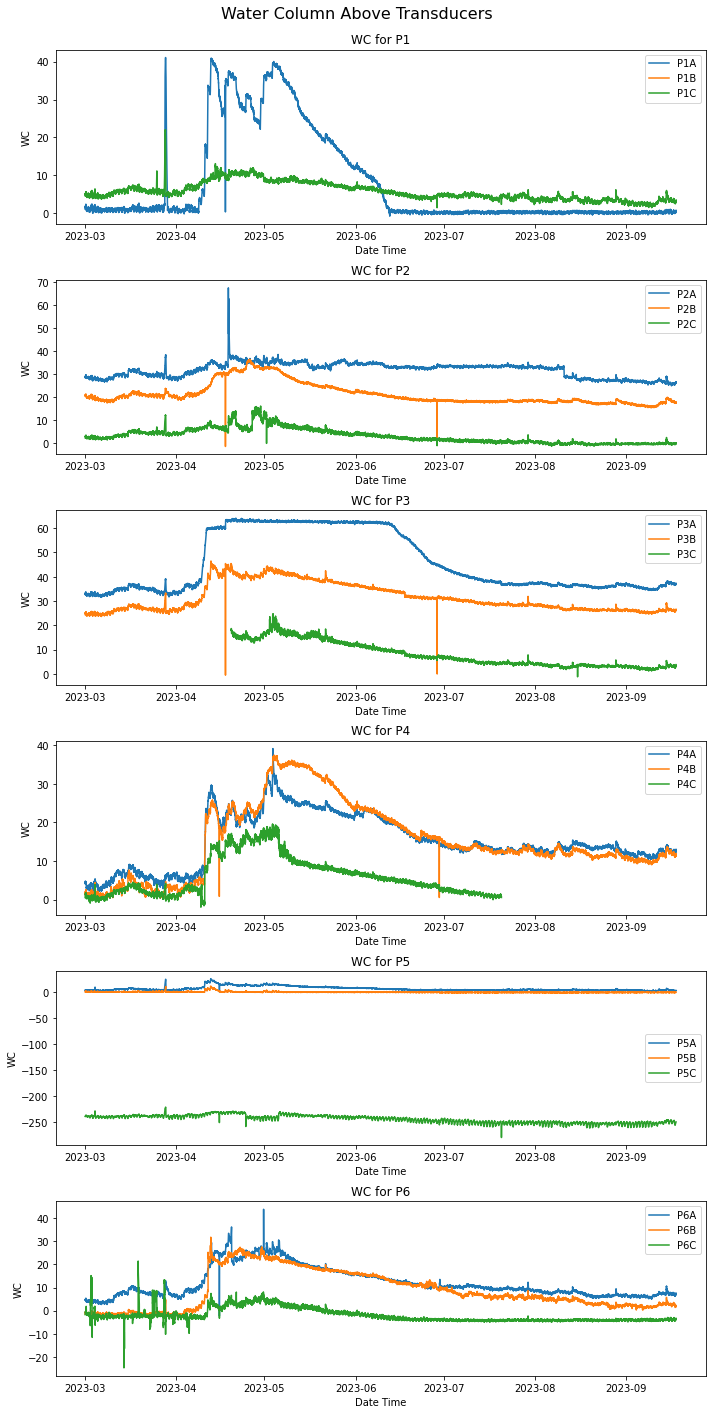

In [19]:
# Create a new figure with 6 subplots
fig, axs = plt.subplots(6, figsize=(10, 20))
fig.patch.set_facecolor('white')

# List of pipe letters
pipes = ['A', 'B', 'C']

# Iterate over the piezometer numbers and the axes
for i, ax in enumerate(axs, start=1):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the DataFrame name
        df_name = f'P{i}{pipe}_23'
        # Get the DataFrame by its variable name
        df = eval(df_name)
        # Plot the 'WC' series
        ax.plot(df['WC'], label=f'P{i}{pipe}')
    # Set the title and labels
    ax.set_title(f'WC for P{i}')
    ax.set_xlabel('Date Time')
    ax.set_ylabel('WC')
    # Add a legend
    ax.legend()

# Adjust the layout
plt.tight_layout()
fig.suptitle('Water Column Above Transducers', fontsize=16)
plt.subplots_adjust(top=0.95)

# Display the plots
plt.savefig('WC_2023.png', dpi=300)
plt.show()

This is how I did it before: 

In [4]:
# use 1 from SM21 to SP22
transducer_depths_1 = [1.016, 0.89, 1.107, 1.122, 1.061, 1.071, 1.088, 1.138, 0.921, 
                        0.696, 0.525, 0.376, 0.526, 0.49, 0.393, 0.604, 0.557, 0.38, 0.67, 0.514, 
                        0.397, 0.711, 0.532, 0.383, 0.643, 0.551, 0.393]
# use 2 from SM22 to SM23
transducer_depths_2 = [0.97, 1.04, 1.04, 1.07, 1.044, 1.054, 1.045, 1.005, 0.988, 0.746, 
                        0.514, 0.398, 0.69, 0.575, 0.428, 0.616, 0.562, 0.293, 0.656, 0.56, 
                        0.384, 0.724, 0.586, 0.477, 0.705, 0.574, 0.40]

densities = pd.read_csv('water_densities.csv', usecols=[0, 1]) 
# this table contains the water density at different temperatures at 1 atm pressure (our barom is a little bit less than that)
# (source: https://www.engineeringtoolbox.com/water-density-specific-weight-d_595.html)

# Extract the temperature and density columns from the densities DataFrame
temp_values = densities['Temperature'].values
density_values = densities['Density (g/cm3)'].values

for i, file in enumerate(files):
    # get the DataFrame name by removing the '.csv' extension from the file name
    df_name = file[:-4]
    if df_name != 'BAROM_SM23': # skip the 'BAROM_SM23' DataFrame
        # get the DataFrame by its variable name
        print(df_name)
        df = eval(df_name)

        #get the parameters
        pressure = df['Pressure']   # Pressure reading in cmH2O
        temp = df['Temperature']    # Water temperature in degrees Celsius
        barom = df['Barom']  # Atmospheric pressure in cmH2O
        d_transducer = transducer_depths_2[i-1] # Depth of the pressure transducer in m (from the list above)

        print('The transducer depth for', df_name, 'is:' , d_transducer, 'm')

        # convert the pressure from cmH2O to Pascals
        barom_pa = barom * 98.0665
        pressure_pa = pressure * 98.0665

        # interpolate the water density at the measured temperature (originally in g/cm3)
        rho = np.interp(temp, temp_values, density_values) * 1000 # convert the density to kg/m3

        # calculate the water depth
        h = ((pressure_pa - barom_pa) / (rho * 9.81))
        # This is how I calculated it for the stilling wells
        # h = ((pressure_pa - barom_pa) / (rho * 9.81)) + (0.5 - d_transducer)

        # add the water depth as a new column to the DataFrame
        df['WaterDepth'] = h

        # Save the DataFrame to a CSV file
        df.to_csv(f"{df_name}_depth.csv")

        # Assign the result back to the DataFrame variable
        exec(f"{df_name} = df")



GW1_SM23
The transducer depth for GW1_SM23 is: 0.97 m
GW2_SM23
The transducer depth for GW2_SM23 is: 1.04 m
GW3_SM23
The transducer depth for GW3_SM23 is: 1.04 m
GW4_SM23
The transducer depth for GW4_SM23 is: 1.07 m
GW5_SM23
The transducer depth for GW5_SM23 is: 1.044 m
GW6_SM23
The transducer depth for GW6_SM23 is: 1.054 m
GW7_SM23
The transducer depth for GW7_SM23 is: 1.045 m
GW8_SM23
The transducer depth for GW8_SM23 is: 1.005 m
GW9_SM23
The transducer depth for GW9_SM23 is: 0.988 m
P1A_SM23
The transducer depth for P1A_SM23 is: 0.746 m
P1B_SM23
The transducer depth for P1B_SM23 is: 0.514 m
P1C_SM23
The transducer depth for P1C_SM23 is: 0.398 m
P2A_SM23
The transducer depth for P2A_SM23 is: 0.69 m
P2B_SM23
The transducer depth for P2B_SM23 is: 0.575 m
P2C_SM23
The transducer depth for P2C_SM23 is: 0.428 m
P3A_SM23
The transducer depth for P3A_SM23 is: 0.616 m
P3B_SM23
The transducer depth for P3B_SM23 is: 0.562 m
P3C_SM23
The transducer depth for P3C_SM23 is: 0.293 m
P4A_SM23
The tr